Hello

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import random
from tqdm import tqdm

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [22]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

In [23]:
#Hyperparameters
BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 3e-4
PATCH_SIZE = 4
NUM_CLASSES = 10
IMAGE_SIZE = 32
EMBED_DIM = 256
CHANNELS = 3
NUM_HEADS = 8
DEPTH = 6
MLP_DIM = 512
DROPOUT = 0.1


In [24]:
#IMAGE TRANSFORMS
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

In [25]:
#DataSet
train_dataset= datasets.CIFAR10(root='data', train=True, download=True, transform=transforms)
test_dataset= datasets.CIFAR10(root='data', train=False, download=True, transform=transforms)
#DataLoader
train_loader= DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader= DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f'Number of training samples: {len(train_dataset)}')
print(f'Number of test samples: {len(test_dataset)}')

Number of training samples: 50000
Number of test samples: 10000


In [26]:
#Vision Transformer (ViT) Model from Scratch
class Patch_Embedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels,embed_dim):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        num_patcehes = (img_size // patch_size) ** 2
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, num_patcehes + 1, embed_dim))
    def forward(self, x):
        B = x.shape[0]  # Get the batch size
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
    # Corrected line: expand the cls_token tensor
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        return (x)


In [27]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, dropout):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, in_features)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        x= self.dropout(F.gelu(self.fc1(x)))
        x= self.dropout(self.fc2(x))
        return x

In [28]:
class Transformer_Encoder(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_dim, dropout)

    def forward(self, x):
        x_norm1 = self.norm1(x)
        attn_output, _ = self.attn(x_norm1, x_norm1, x_norm1)
        x = x + attn_output  # Residual connection
        x_norm2 = self.norm2(x)
        x = x + self.mlp(x_norm2)  # Residual connection
        return x

In [29]:


class ViT(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, num_classes, embed_dim, depth, num_heads, mlp_dim, dropout):
        super().__init__()
        self.patch_embed = Patch_Embedding(img_size, patch_size, in_channels, embed_dim)
        self.encoder_layers = nn.ModuleList([
            Transformer_Encoder(embed_dim, num_heads, mlp_dim, dropout) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)  # [B, N+1, D]
        for layer in self.encoder_layers:
            x = layer(x)
        x = self.norm(x)
        cls_token_final = x[:, 0]  # CLS token
        x = self.head(cls_token_final)
        return x

In [30]:
#Instant
model = ViT(IMAGE_SIZE, PATCH_SIZE, CHANNELS, NUM_CLASSES, EMBED_DIM, DEPTH, NUM_HEADS, MLP_DIM, DROPOUT).to(device)
model

ViT(
  (patch_embed): Patch_Embedding(
    (proj): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
  )
  (encoder_layers): ModuleList(
    (0-5): 6 x Transformer_Encoder(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=256, out_features=10, bias=True)
)

In [31]:
#loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [32]:
# Training loop
def Train_Vit(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

In [33]:
def eval1(model, loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            correct += (out.argmax(1) == y).sum().item()
    return correct / len(loader.dataset)

In [34]:
# Training
train_accuracies, test_accuracies = [], []
for epoch in range(EPOCHS):
    train_loss, train_acc = Train_Vit(model, train_loader, optimizer, loss_fn)
    test_acc = eval1(model, test_loader)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

Epoch 1/20, Train Loss: 1.6810, Train Acc: 0.3915, Test Acc: 0.4821
Epoch 2/20, Train Loss: 1.3460, Train Acc: 0.5164, Test Acc: 0.5378
Epoch 3/20, Train Loss: 1.2063, Train Acc: 0.5666, Test Acc: 0.5819
Epoch 4/20, Train Loss: 1.1015, Train Acc: 0.6072, Test Acc: 0.5857
Epoch 5/20, Train Loss: 1.0223, Train Acc: 0.6358, Test Acc: 0.6100
Epoch 6/20, Train Loss: 0.9483, Train Acc: 0.6621, Test Acc: 0.6244
Epoch 7/20, Train Loss: 0.8761, Train Acc: 0.6866, Test Acc: 0.6258
Epoch 8/20, Train Loss: 0.8074, Train Acc: 0.7134, Test Acc: 0.6370
Epoch 9/20, Train Loss: 0.7414, Train Acc: 0.7351, Test Acc: 0.6345
Epoch 10/20, Train Loss: 0.6709, Train Acc: 0.7595, Test Acc: 0.6321
Epoch 11/20, Train Loss: 0.6106, Train Acc: 0.7814, Test Acc: 0.6253
Epoch 12/20, Train Loss: 0.5551, Train Acc: 0.8001, Test Acc: 0.6344
Epoch 13/20, Train Loss: 0.4936, Train Acc: 0.8239, Test Acc: 0.6416
Epoch 14/20, Train Loss: 0.4445, Train Acc: 0.8403, Test Acc: 0.6403
Epoch 15/20, Train Loss: 0.3986, Train Acc:

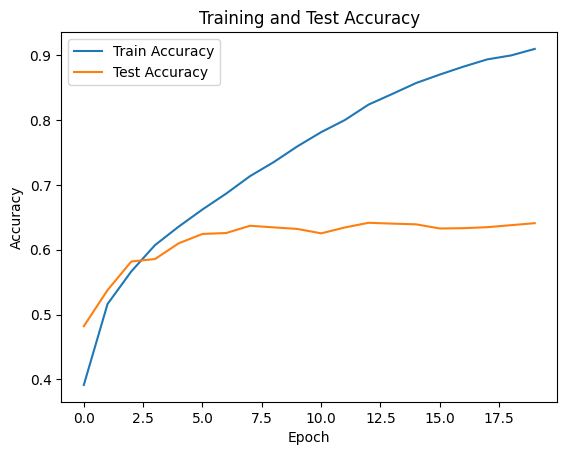

In [35]:
# accuracy
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Test Accuracy')
plt.show()

In [36]:
import random
def predict_and_plot_grid(model,
                          dataset,
                          classes,
                          grid_size=3):
    model.eval()
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(9, 9))
    for i in range(grid_size):
        for j in range(grid_size):
            idx = random.randint(0, len(dataset) - 1)
            img, true_label = dataset[idx]
            input_tensor = img.unsqueeze(dim=0).to(device)
            with torch.inference_mode():
                output = model(input_tensor)
                _, predicted = torch.max(output.data, 1)
            img = img / 2 + 0.5
            npimg = img.cpu().numpy()
            axes[i, j].imshow(np.transpose(npimg, (1, 2, 0)))
            color = classes[true_label] == classes[predicted.item()]
            if color:
                c = "g"
            else:
                c = "r"
            axes[i, j].set_title(f"Truth: {classes[true_label]}\n, Predicted: {classes[predicted.item()]}", fontsize=10, c=c)
            axes[i, j].axis("off")
    plt.tight_layout()
    plt.show()

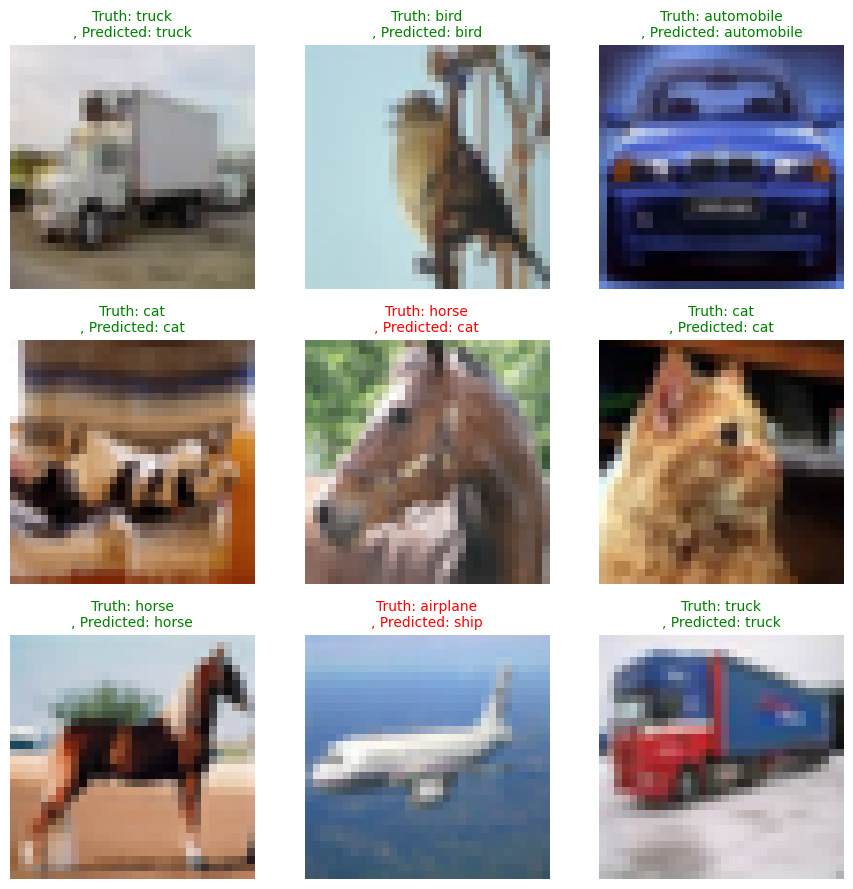

In [37]:
predict_and_plot_grid(model, test_dataset, classes=train_dataset.classes, grid_size=3)